In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
import torch.nn as nn
import torchvision
import gc

from src import distributions
import torch.nn.functional as F

from src.resnet2 import ResNet_D
from src.unet import UNet

from src.tools import unfreeze, freeze
from src.tools import weights_init_D
from src.tools import load_dataset, get_pushed_loader_stats
from src.fid_score import calculate_frechet_distance
from src.plotters import plot_random_images, plot_images

from copy import deepcopy
import json
from munch import Munch
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import wandb # <--- online logging of the results
from src.tools import fig2data, fig2img # for wandb

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

In [3]:
from models.ncsnpp.discriminator import Discriminator_small, Discriminator_large, Discriminator_largest
from models.ncsnpp.ncsnpp_generator_adagn import NCSNpp


Tconfig = Munch()
Tconfig.not_use_tanh = False
Tconfig.z_emb_dim = 256
Tconfig.nz = 100
Tconfig.num_channels_dae = 128
Tconfig.ch_mult = [1, 2, 2, 2]
Tconfig.num_res_blocks = 2
Tconfig.attn_resolutions = (16,)
Tconfig.dropout = 0
Tconfig.resamp_with_conv = True
Tconfig.image_size = 64
Tconfig.fir = True
Tconfig.fir_kernel = [1, 3, 3, 1]
Tconfig.skip_rescale = True
Tconfig.resblock_type = 'biggan'
Tconfig.progressive = 'none'
Tconfig.progressive_input = 'residual'
Tconfig.embedding_type = 'positional'
Tconfig.progressive_combine = 'sum'
Tconfig.fourier_scale = '16.'
Tconfig.num_channels = 3
Tconfig.n_mlp = 4
Tconfig.centered = True

## Main Config

In [4]:
DEVICE_IDS = [0]

# DATASET1, DATASET1_PATH = 'handbag', '../../data/handbag_128.hdf5'
# DATASET2, DATASET2_PATH = 'shoes', '../../data/shoes_128.hdf5'

# DATASET1, DATASET1_PATH = 'celeba_female', '../../data/img_align_celeba'
# DATASET2, DATASET2_PATH = 'aligned_anime_faces', '../../data/aligned_anime_faces'

DATASET1, DATASET1_PATH = 'male', '../datasets/male64train'
DATASET2, DATASET2_PATH = 'female', '../datasets/female64train'

T_ITERS = 10
f_LR, T_LR = 1e-4, 1e-4
IMG_SIZE = 64

BATCH_SIZE = 32

PLOT_INTERVAL = 50
COST = 'mse' # Mean Squared Error
CPKT_INTERVAL = 500
MAX_STEPS = 100001
SEED = 0x000000

EXP_NAME = f'{DATASET1}_{DATASET2}_T{T_ITERS}_{COST}_{IMG_SIZE}'
OUTPUT_PATH = '../checkpoints/{}/{}_{}_{}/'.format(COST, DATASET1, DATASET2, IMG_SIZE)

## Preparation

In [5]:
config = dict(
    DATASET1=DATASET1,
    DATASET2=DATASET2, 
    T_ITERS=T_ITERS,
    f_LR=f_LR, T_LR=T_LR,
    BATCH_SIZE=BATCH_SIZE
)
    
assert torch.cuda.is_available()
torch.cuda.set_device(f'cuda:{DEVICE_IDS[0]}')
torch.manual_seed(SEED); np.random.seed(SEED)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

## Loading data stats for testing

In [6]:
# filename = '../stats/{}_{}_test.json'.format(DATASET2, IMG_SIZE)
# with open(filename, 'r') as fp:
#     data_stats = json.load(fp)
#     mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
# del data_stats

filename = '../datasets/{}{}train.npz'.format(DATASET2, IMG_SIZE)
stats = np.load(filename)
mu_data, sigma_data = stats['mu'], stats['sigma']
del stats

## Prepare Samplers (X, Y)

In [7]:
DATASET2, IMG_SIZE

('female', 64)

In [8]:
X_sampler, X_test_sampler = load_dataset(DATASET1, DATASET1_PATH, img_size=IMG_SIZE)
Y_sampler, Y_test_sampler = load_dataset(DATASET2, DATASET2_PATH, img_size=IMG_SIZE)
    
# torch.cuda.empty_cache(); gc.collect()
# clear_output()

# Initializing Networks

In [9]:
Tconfig

Munch({'not_use_tanh': False, 'z_emb_dim': 256, 'nz': 100, 'num_channels_dae': 128, 'ch_mult': [1, 2, 2, 2], 'num_res_blocks': 2, 'attn_resolutions': (16,), 'dropout': 0, 'resamp_with_conv': True, 'image_size': 64, 'fir': True, 'fir_kernel': [1, 3, 3, 1], 'skip_rescale': True, 'resblock_type': 'biggan', 'progressive': 'none', 'progressive_input': 'residual', 'embedding_type': 'positional', 'progressive_combine': 'sum', 'fourier_scale': '16.', 'num_channels': 3, 'n_mlp': 4, 'centered': True})

In [10]:
T = NCSNpp(Tconfig).cuda()
f = Discriminator_large(nc = 3, ngf = 64, act=torch.nn.LeakyReLU(0.2)).cuda()

In [11]:
print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 48103811
f params: 26876929


In [12]:
# f = ResNet_D(IMG_SIZE, nc=3).cuda()
# f.apply(weights_init_D)

# T = UNet(3, 3, base_factor=48).cuda()

# if len(DEVICE_IDS) > 1:
#     T = nn.DataParallel(T, device_ids=DEVICE_IDS)
#     f = nn.DataParallel(f, device_ids=DEVICE_IDS)
    
# print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
# print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

In [13]:
torch.manual_seed(0xBADBEEF); np.random.seed(0xBADBEEF)
X_fixed = X_sampler.sample(10)
Y_fixed = Y_sampler.sample(10)
X_test_fixed = X_test_sampler.sample(10)
Y_test_fixed = Y_test_sampler.sample(10)

### Plots Test

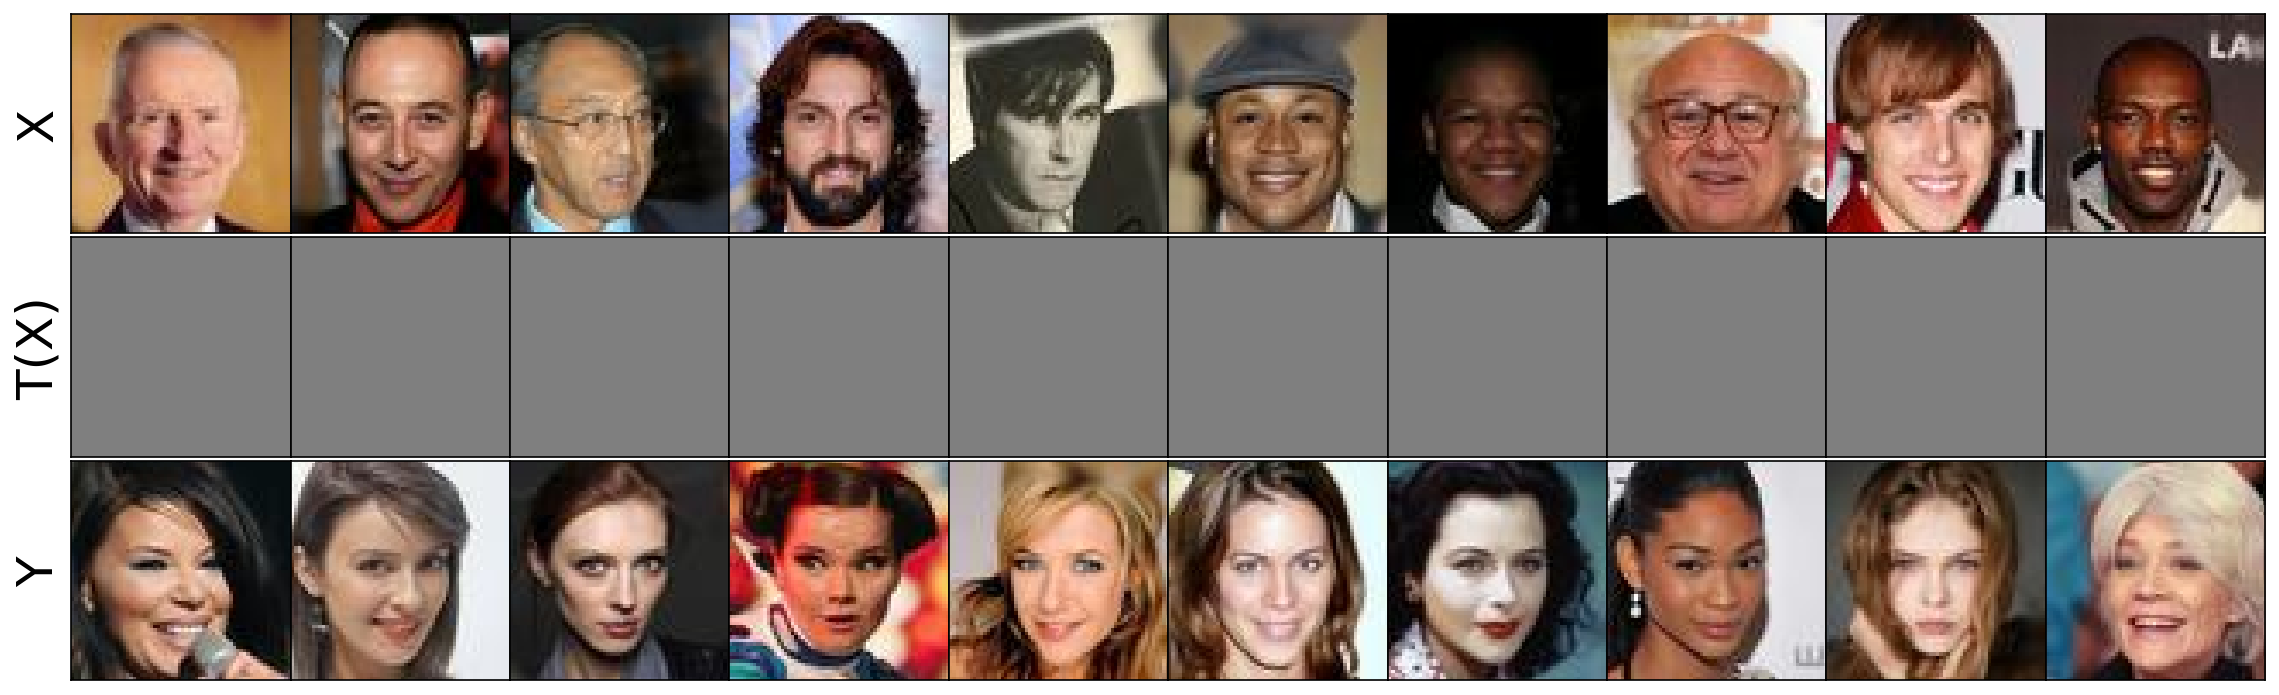

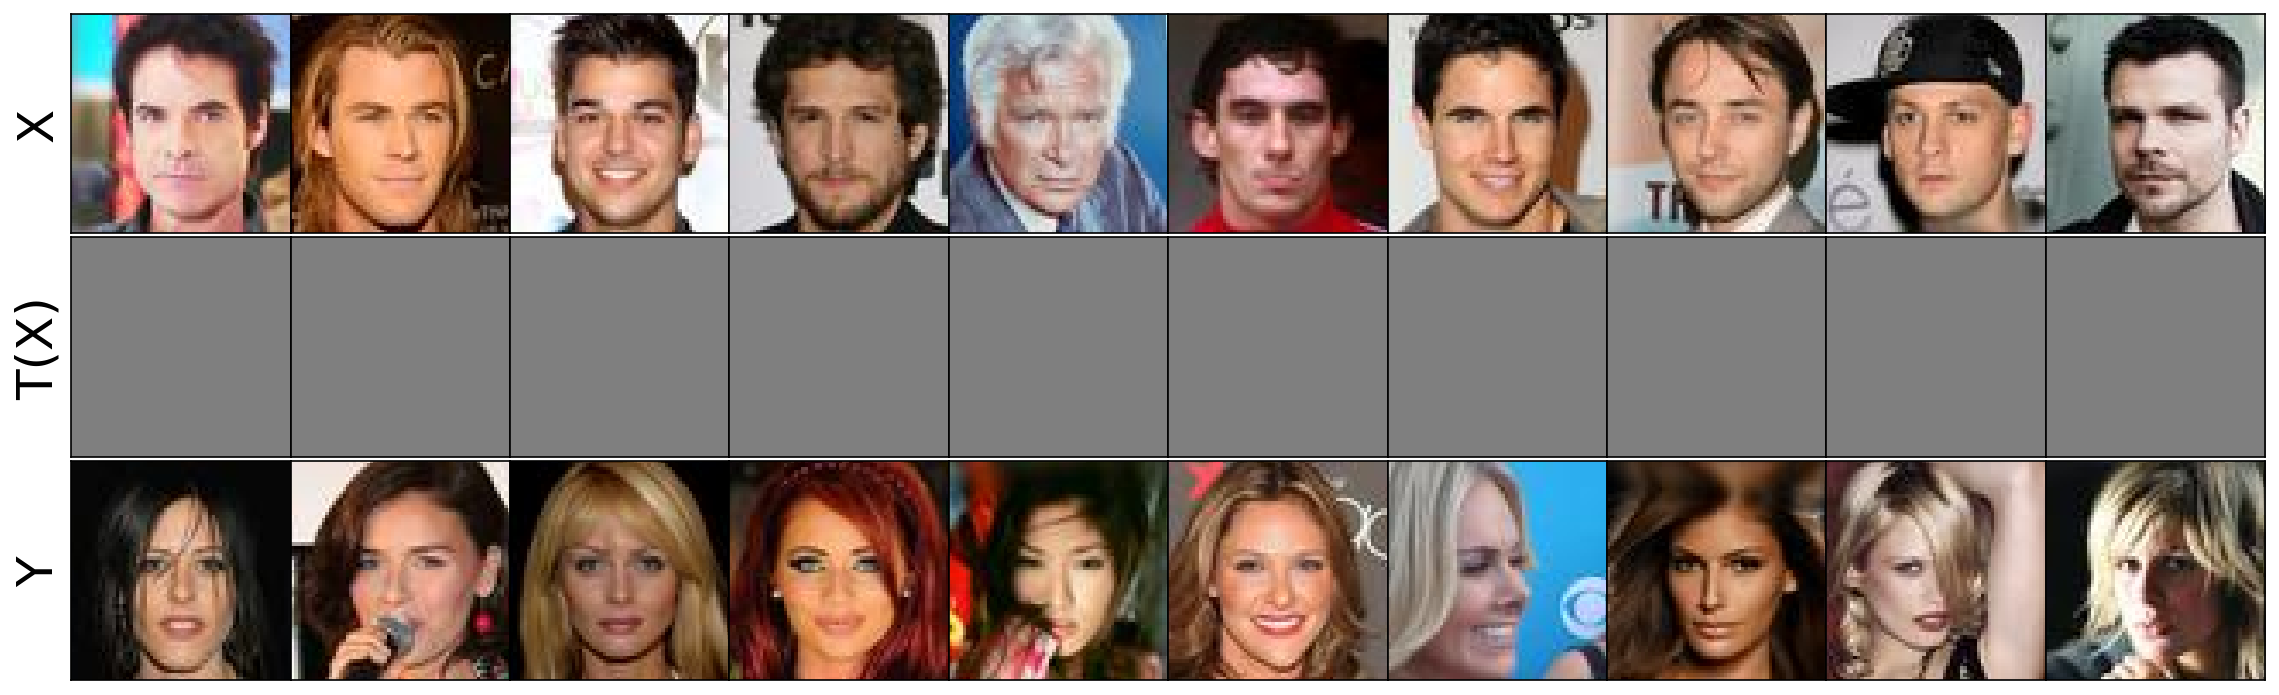

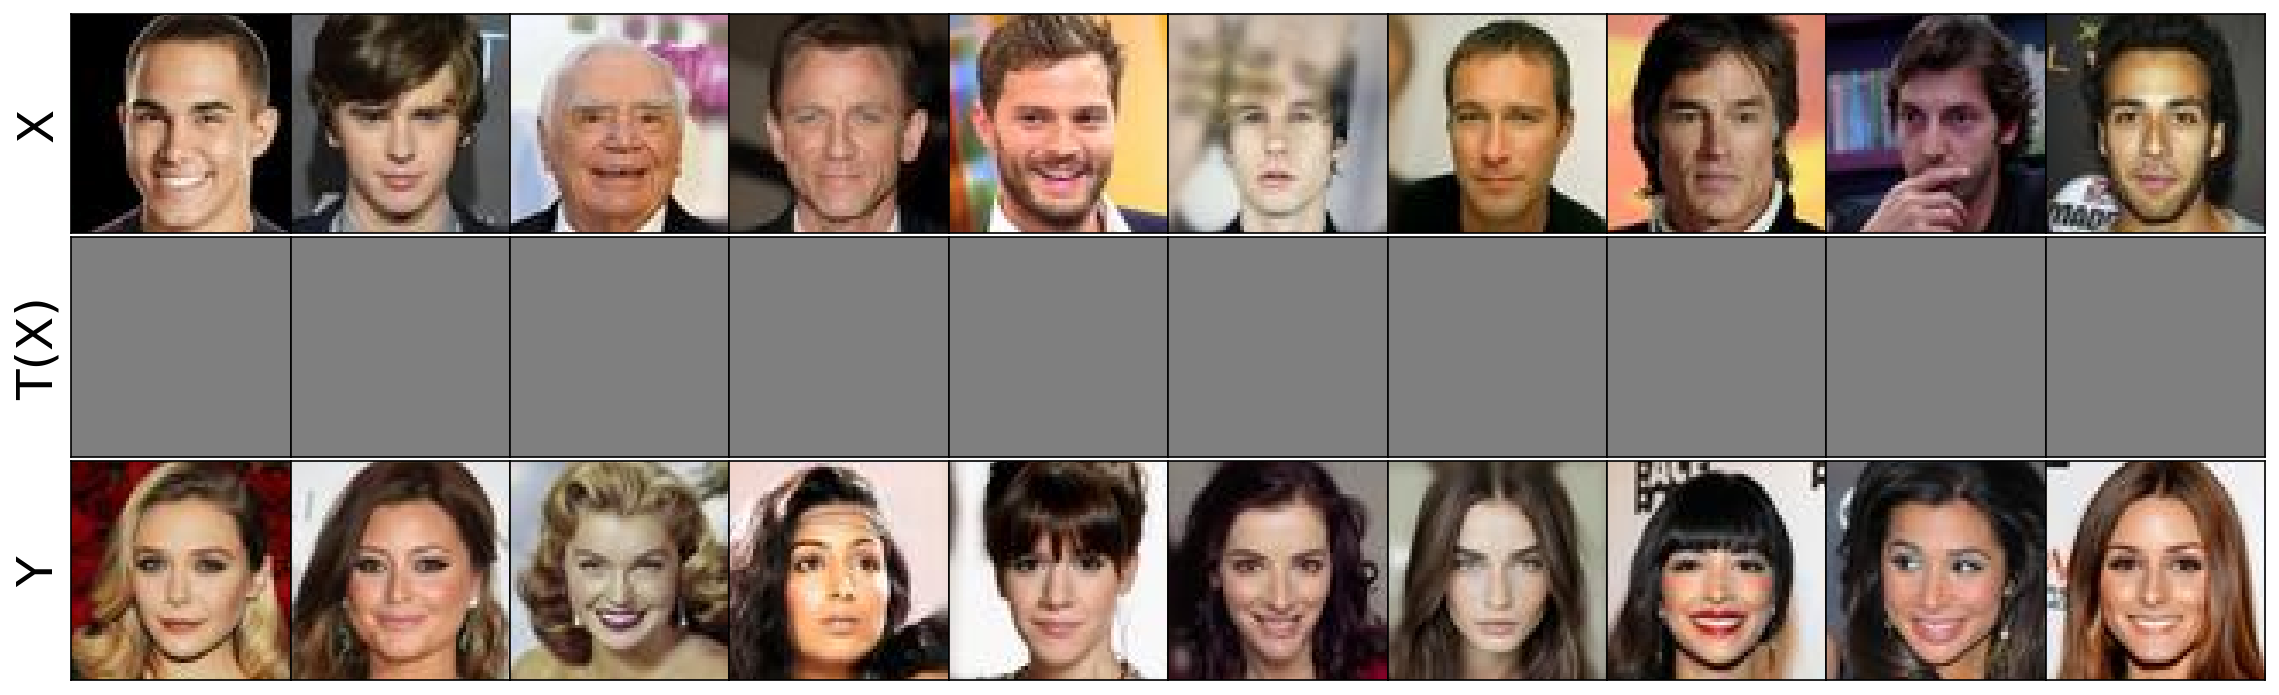

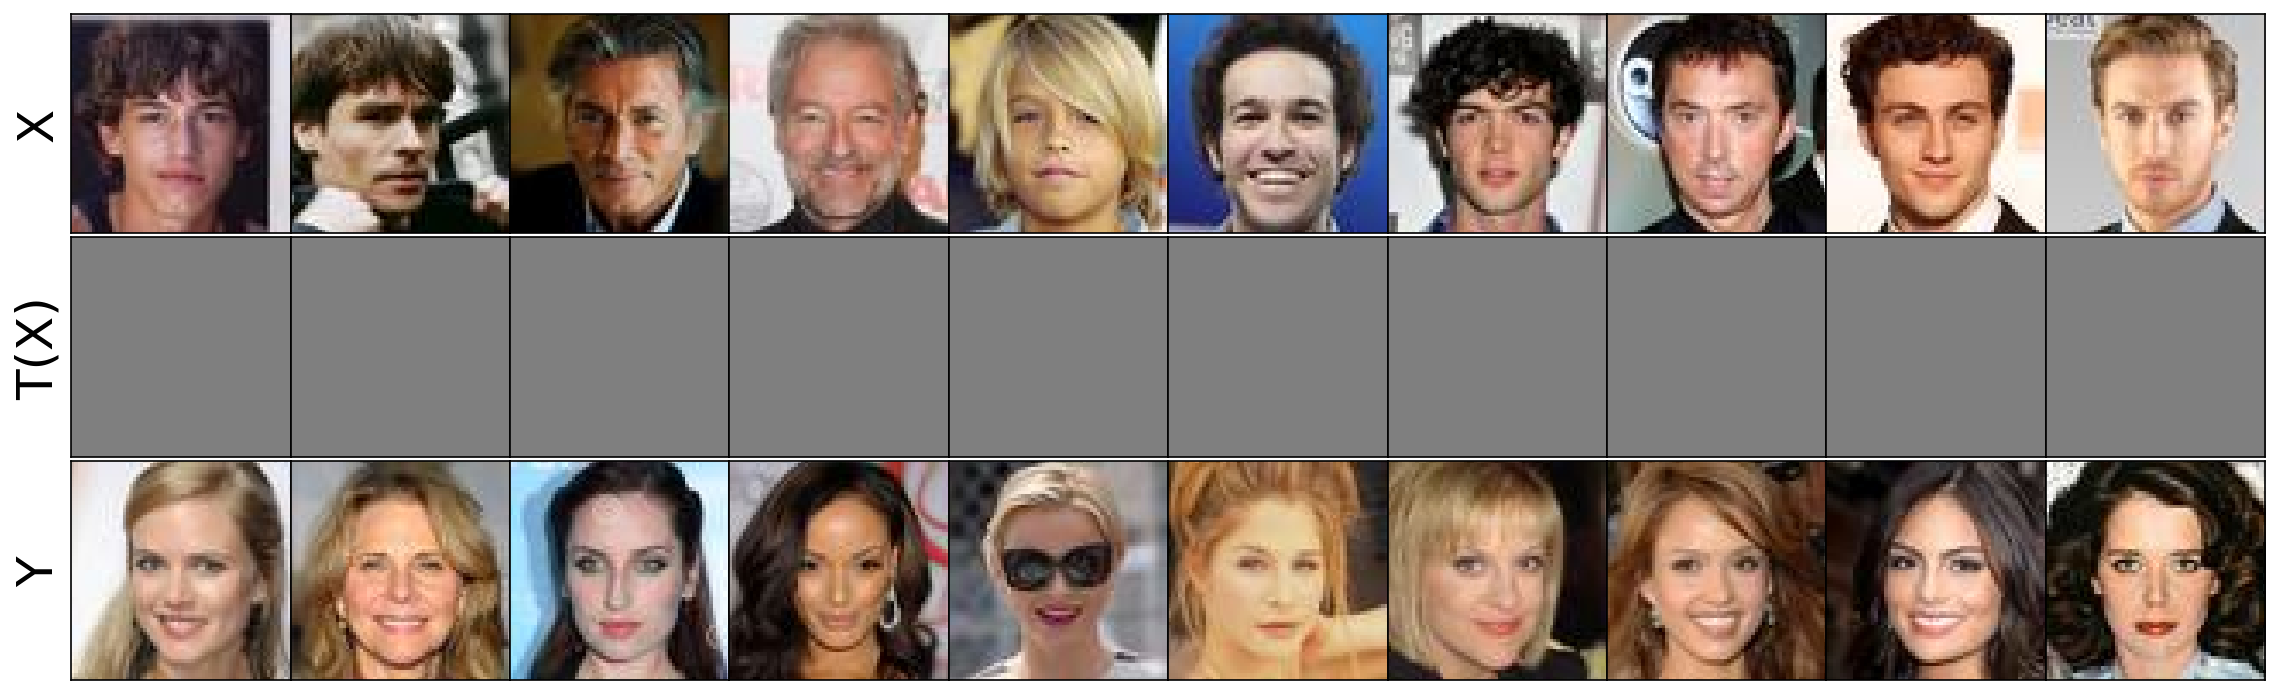

In [16]:
fig, axes = plot_images(X_fixed, Y_fixed, T)
fig, axes = plot_random_images(X_sampler, Y_sampler, T)
fig, axes = plot_images(X_test_fixed, Y_test_fixed, T)
fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)

# Run Training

In [17]:
wandb.init(name=EXP_NAME, project='notreallyweakot', config=config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ilyasudakov (sudakov). Use `wandb login --relogin` to force relogin


In [18]:
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)

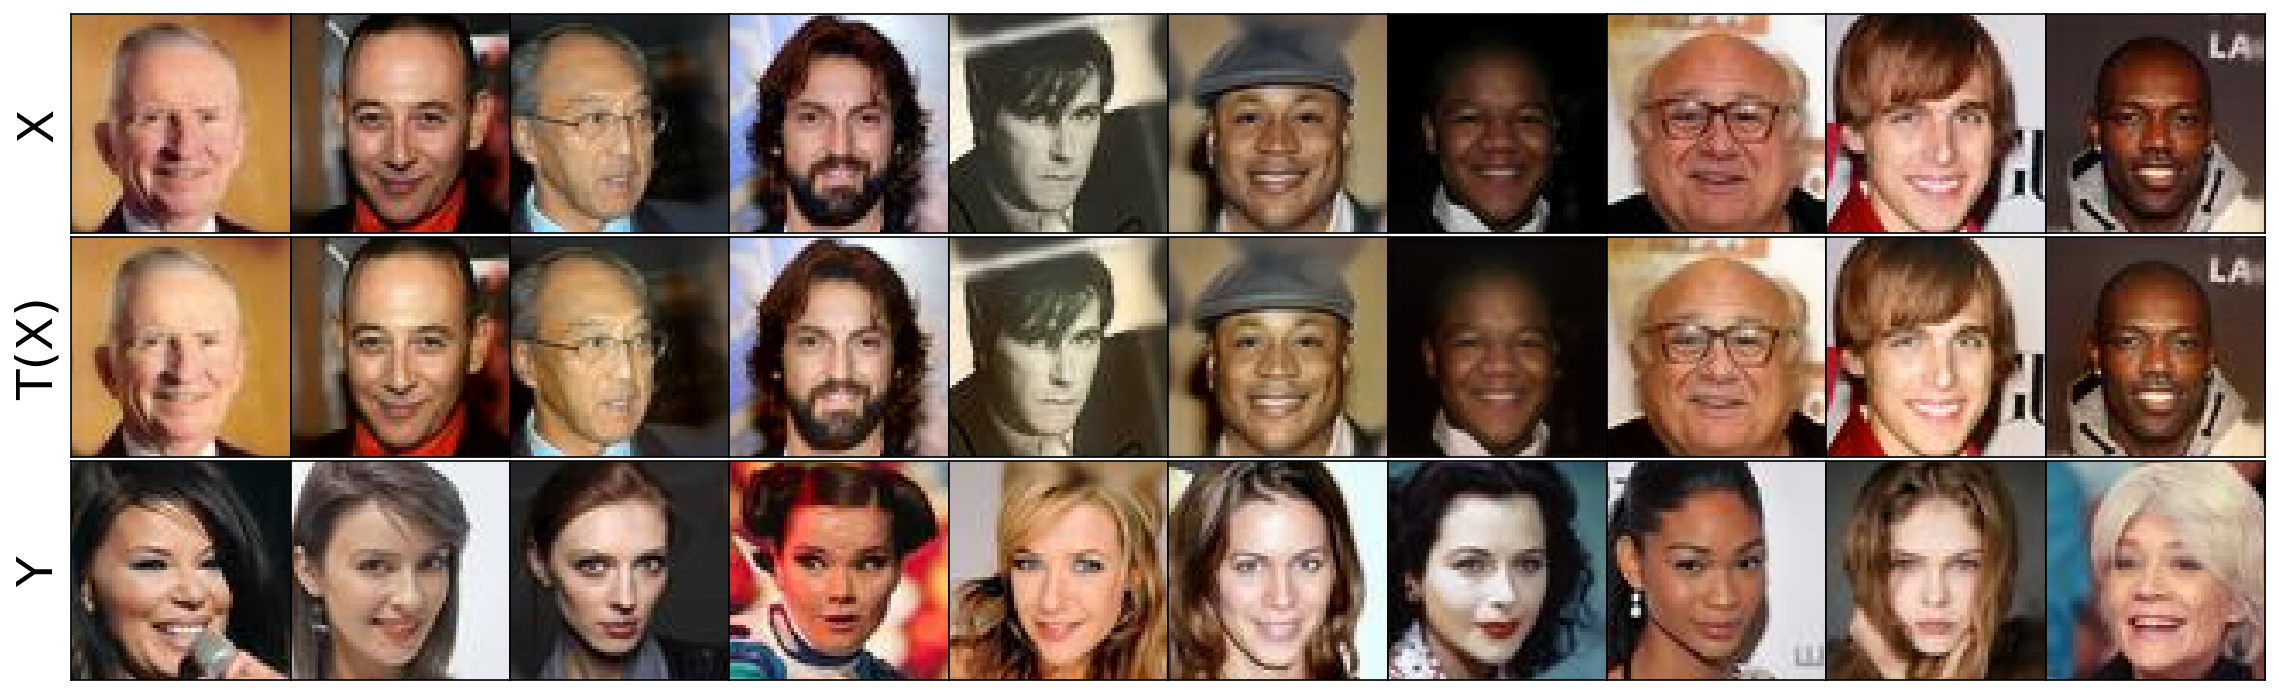

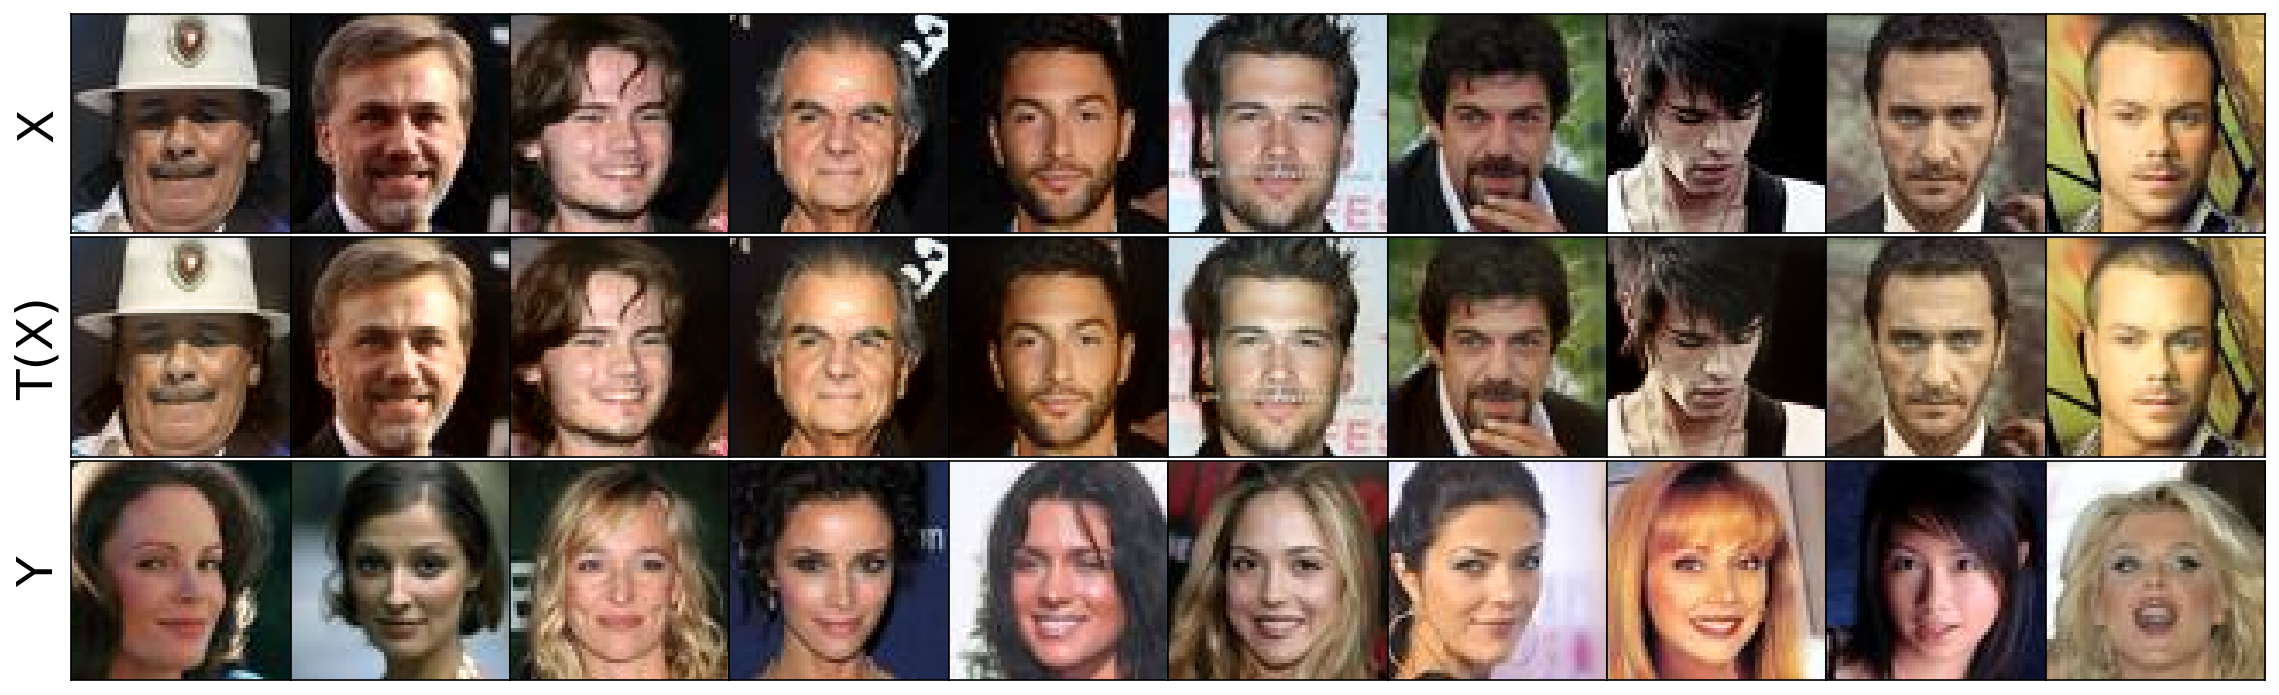

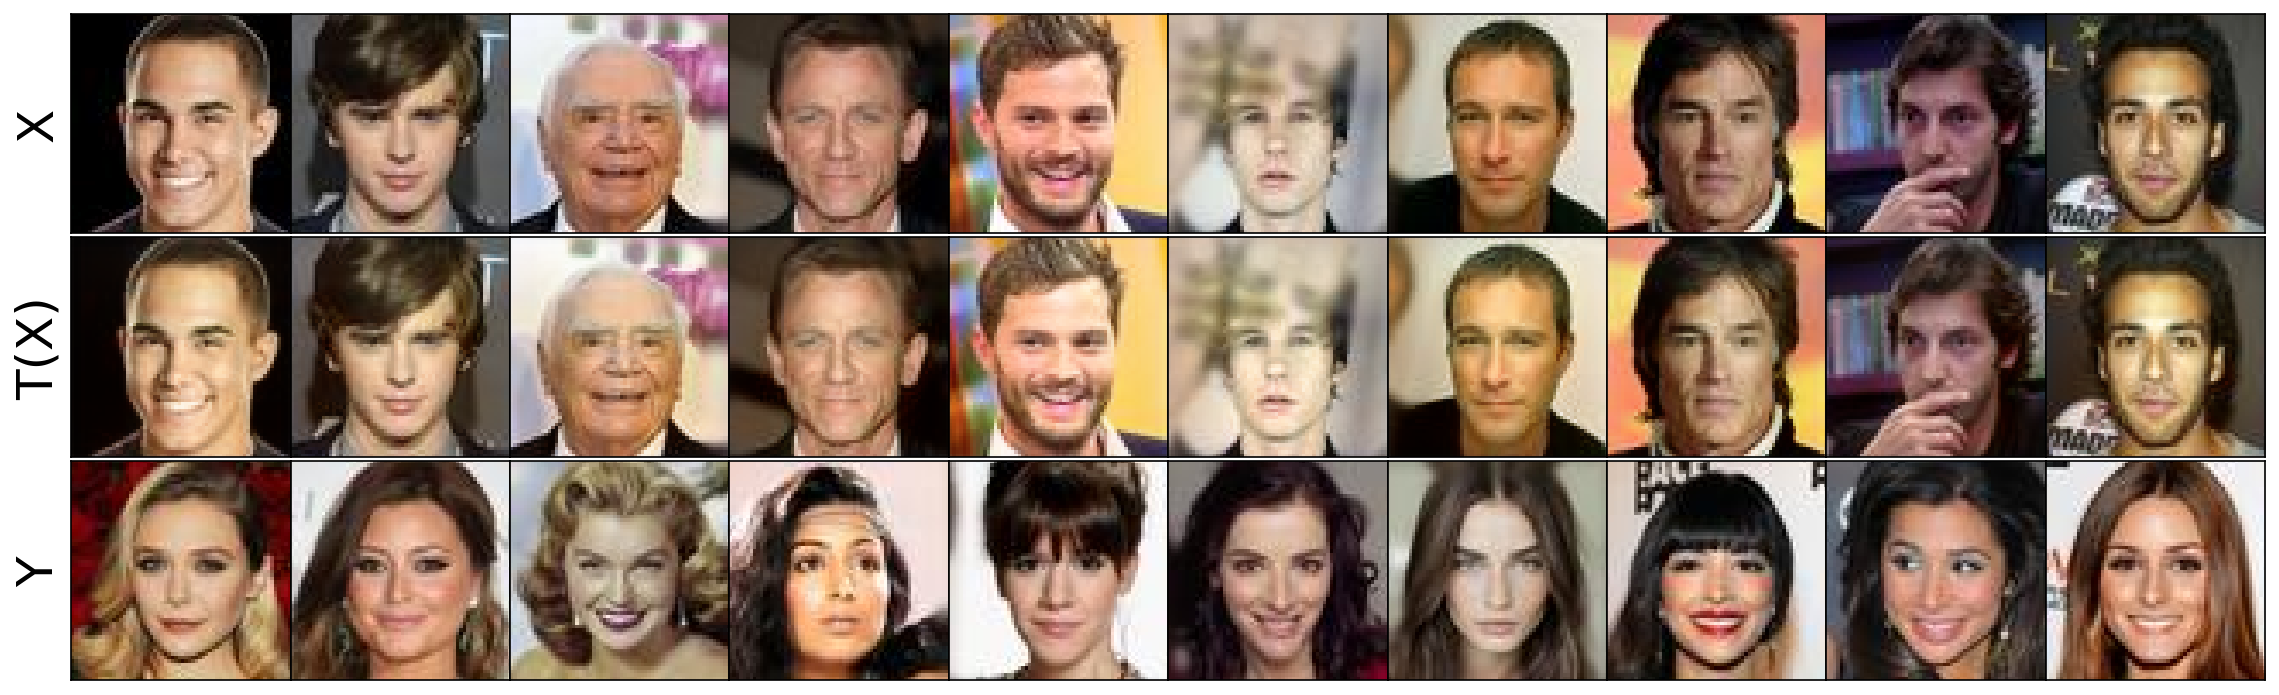

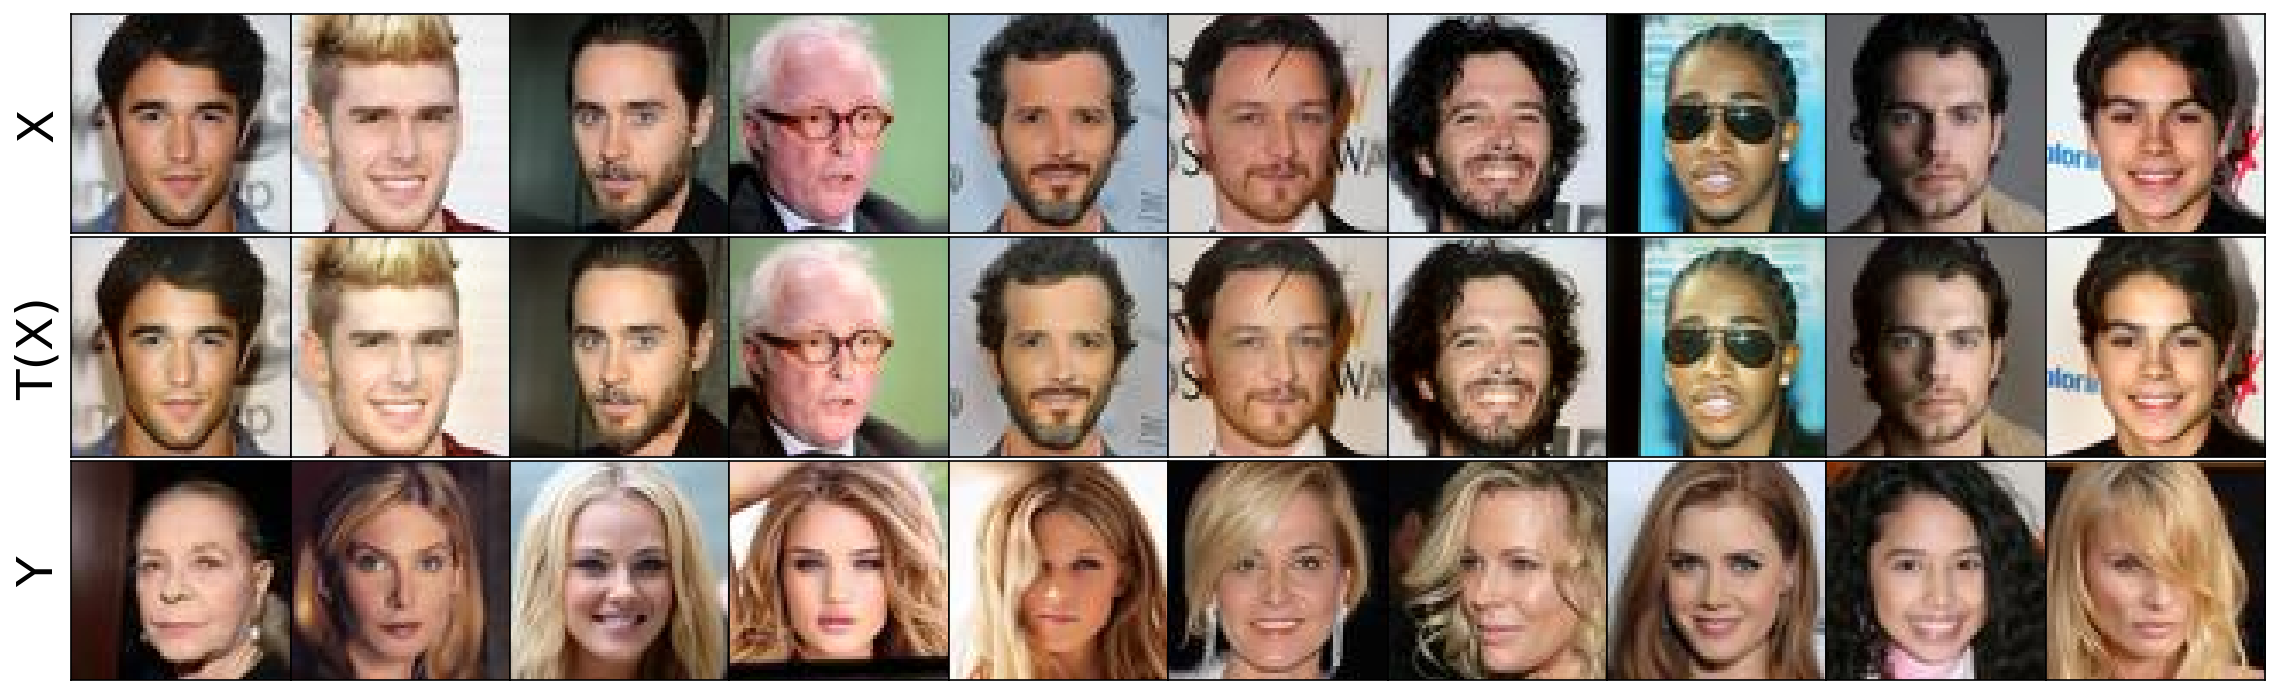

Computing FID


In [ ]:
for step in tqdm(range(MAX_STEPS)):
    # T optimization
    unfreeze(T); freeze(f)
    for t_iter in range(T_ITERS): 
        T_opt.zero_grad()
        X = X_sampler.sample(BATCH_SIZE)
        with torch.no_grad():
            latent_z = torch.randn(X.shape[0], T.nz)*0.1
        T_X = T(X, latent_z.cuda())
        if COST == 'mse':
            T_loss = F.mse_loss(X, T_X).mean() - f(T_X).mean()
        else:
            raise Exception('Unknown COST')
        T_loss.backward(); T_opt.step()
    wandb.log({f'T_loss' : T_loss.item()}, step=step) 
    del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()

    # f optimization
    freeze(T); unfreeze(f)
    X = X_sampler.sample(BATCH_SIZE)
    with torch.no_grad():
        latent_z = torch.randn(X.shape[0], T.nz)*0.1
        T_X = T(X, latent_z.cuda())
    Y = Y_sampler.sample(BATCH_SIZE)
    f_opt.zero_grad()
    f_loss = f(T_X).mean() - f(Y).mean()
    f_loss.backward(); f_opt.step();
    wandb.log({f'f_loss' : f_loss.item()}, step=step) 
    del f_loss, Y, X, T_X; gc.collect(); torch.cuda.empty_cache()
        
    if step % PLOT_INTERVAL == 0:
        print('Plotting')
        clear_output(wait=True)
        
        fig, axes = plot_images(X_fixed, Y_fixed, T)
        wandb.log({'Fixed Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_images(X_sampler,  Y_sampler, T)
        wandb.log({'Random Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_images(X_test_fixed, Y_test_fixed, T)
        wandb.log({'Fixed Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)
        wandb.log({'Random Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 

        freeze(T); 
        print('Computing FID')
        mu, sigma, l2 = get_pushed_loader_stats(T, X_test_sampler.loader)
        fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
        wandb.log({f'FID (Test)' : fid}, step=step)
        wandb.log({f'l2 (Test)' : l2}, step=step)
        del mu, sigma
    
    if step % CPKT_INTERVAL == 0:
        torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'{SEED}_{step}.pt'))
        torch.save(f.state_dict(), os.path.join(OUTPUT_PATH, f'f_{SEED}_{step}.pt'))
        torch.save(f_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_opt_{SEED}_{step}.pt'))
        torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{step}.pt'))
    
    gc.collect(); torch.cuda.empty_cache()